📥 Loading Fake and True news datasets...
🧹 Cleaning text...
🔀 Splitting dataset (80% train / 20% test)...
⚖️ Computing class weights...
🔤 Tokenizing text...
🧠 Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚙️ Setting training arguments...
🚦 Training started...


/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001900,0.005472,0.998998,0.998949,0.999533,0.998366
2,0.000000,0.004822,0.999332,0.999300,0.999533,0.999066
3,0.000000,0.005329,0.999443,0.999416,0.999766,0.999066


✅ Training complete.
📈 Evaluating on test set...



📊 Classification Report:
              precision    recall  f1-score   support

        Fake   0.999149  0.999574  0.999361      4696
        Real   0.999533  0.999066  0.999300      4284

    accuracy                       0.999332      8980
   macro avg   0.999341  0.999320  0.999330      8980
weighted avg   0.999332  0.999332  0.999332      8980


🧮 Confusion Matrix:
[[4694    2]
 [   4 4280]]


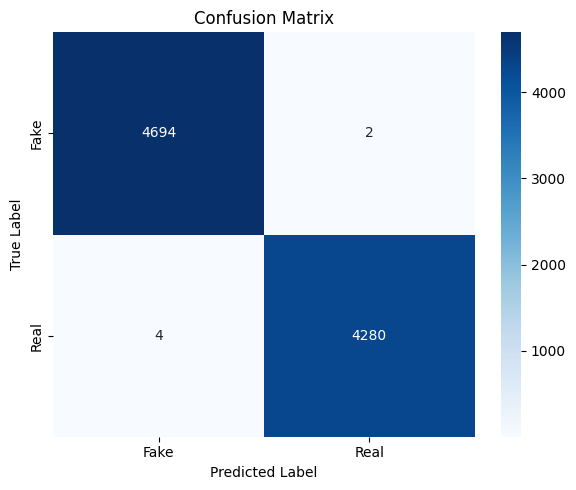

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns



print("📥 Loading Fake and True news datasets...")
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

true_df["label"] = 1  # Real
fake_df["label"] = 0  # Fake

df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)
text_column = "text" if "text" in df.columns else df.columns[0]

print("🧹 Cleaning text...")
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df[text_column] = df[text_column].apply(clean_text)

print("🔀 Splitting dataset (80% train / 20% test)...")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

print("⚖️ Computing class weights...")
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=train_df["label"].values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("🔤 Tokenizing text...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df[text_column].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df[text_column].tolist(), truncation=True, padding=True, max_length=128)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})

print("🧠 Loading BERT model...")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

print("⚙️ Setting training arguments...")
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        "f1": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[2],
        "precision": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[0],
        "recall": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[1],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("🚦 Training started...")
trainer.train()
print("✅ Training complete.")

print("📈 Evaluating on test set...")
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"], digits=6))

print("\n🧮 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
#top 1 most common word removed "reuters"

📥 Loading Fake and True news datasets...
🧹 Cleaning text...
🔍 Identifying top 1 frequent word...
🗑️ Removing top word: 'the'
🔀 Splitting dataset (80/20)...
⚖️ Computing class weights...
🔤 Tokenizing...
🧠 Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚙️ Setting training arguments...


/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


🚀 Training started...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000000,0.010711,0.998552,0.998481,0.999299,0.997666
2,0.000000,0.004615,0.999443,0.999416,0.999533,0.999300
3,0.000000,0.005750,0.999332,0.999300,0.999300,0.999300


✅ Training complete.
📈 Evaluating on test set...



📊 Classification Report:
              precision    recall  f1-score   support

        Fake   0.999361  0.999574  0.999468      4696
        Real   0.999533  0.999300  0.999416      4284

    accuracy                       0.999443      8980
   macro avg   0.999447  0.999437  0.999442      8980
weighted avg   0.999443  0.999443  0.999443      8980


🧮 Confusion Matrix:
[[4694    2]
 [   3 4281]]


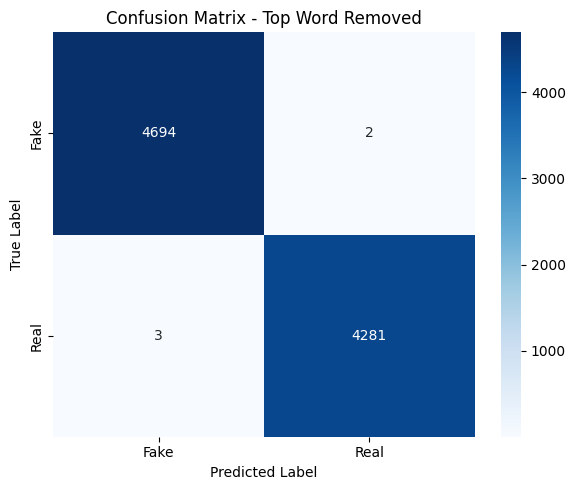

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

print("📥 Loading Fake and True news datasets...")
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")
true_df["label"] = 1
fake_df["label"] = 0
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

text_column = "text" if "text" in df.columns else df.columns[0]

print("🧹 Cleaning text...")
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text) # Remove words with numbers
    return text

df[text_column] = df[text_column].apply(clean_text)

# 🔍 Identify most frequent word
print("🔍 Identifying top 1 frequent word...")
all_words = " ".join(df[text_column]).split()
most_common_word, _ = Counter(all_words).most_common(1)[0]
print(f"🗑️ Removing top word: '{most_common_word}'")

# Remove the top 1 word from each row
def remove_top_word(text):
    return " ".join([word for word in text.split() if word != most_common_word])

df[text_column] = df[text_column].apply(remove_top_word)

# 🔀 Train/Test Split
print("🔀 Splitting dataset (80/20)...")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# ⚖️ Class weights
print("⚖️ Computing class weights...")
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=train_df["label"].values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# 🔤 Tokenization
print("🔤 Tokenizing...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df[text_column].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df[text_column].tolist(), truncation=True, padding=True, max_length=128)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})

# 🧠 BERT Model
print("🧠 Loading BERT model...")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# 🔧 Custom Trainer with Weighted Loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ⚙️ Training Args
print("⚙️ Setting training arguments...")
training_args = TrainingArguments(
    output_dir="./results_removed_topword",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# 🚦 Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        "f1": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[2],
        "precision": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[0],
        "recall": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[1],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("🚀 Training started...")
trainer.train()
print("✅ Training complete.")

# 📈 Evaluation
print("📈 Evaluating on test set...")
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"], digits=6))

print("\n🧮 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Top Word Removed")
plt.tight_layout()
plt.show()
